#Cellula Task2: Booking Status Classification

#Developed By: Eng. Waleed Shaban

### Connect to Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries

In [3]:
!pip install scikeras

In [4]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

from imblearn.over_sampling import RandomOverSampler

import joblib
warnings.filterwarnings('ignore')
set_config(display='diagram')

### Define Utilities

In [5]:
def compare_features(df:pd.DataFrame, feature_1:str, feature_2:str):
    fig, axs = plt.subplots(2, 1, figsize=(8, 8))
    # Set the title for the entire figure
    fig.suptitle(f'Distribution of {feature_1} Vs {feature_2}')
    sns.histplot(df[feature_1], ax=axs[0])
    sns.histplot(df[feature_2], ax=axs[1])
    # Set the space between sub figures
    plt.subplots_adjust(hspace=0.2)
    plt.show()

##Step 1: Data Overview & Data Preprocessing

### Read & Explore The Data

In [6]:
data_path = '/content/drive/MyDrive/Datasets/first inten project.csv'
df = pd.read_csv(data_path)
df.head(10)

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled
5,INN00006,1,0,0,2,Meal Plan 2,0,Room_Type 1,346,Offline,0,0,0,100.00,1,9/13/2016,Canceled
6,INN00007,1,1,1,4,Meal Plan 1,0,Room_Type 1,34,Online,0,0,0,107.55,1,10/15/2017,Not_Canceled
7,INN00008,3,0,1,3,Meal Plan 1,0,Room_Type 4,83,Online,0,0,0,105.61,1,12/26/2018,Not_Canceled
8,INN00009,1,1,0,4,Meal Plan 1,0,Room_Type 1,121,Offline,0,0,0,96.90,1,7/6/2018,Not_Canceled
9,INN00010,2,0,0,5,Meal Plan 1,0,Room_Type 4,44,Online,0,0,0,133.44,3,10/18/2018,Not_Canceled


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                36285 non-null  object 
 1   number of adults          36285 non-null  int64  
 2   number of children        36285 non-null  int64  
 3   number of weekend nights  36285 non-null  int64  
 4   number of week nights     36285 non-null  int64  
 5   type of meal              36285 non-null  object 
 6   car parking space         36285 non-null  int64  
 7   room type                 36285 non-null  object 
 8   lead time                 36285 non-null  int64  
 9   market segment type       36285 non-null  object 
 10  repeated                  36285 non-null  int64  
 11  P-C                       36285 non-null  int64  
 12  P-not-C                   36285 non-null  int64  
 13  average price             36285 non-null  float64
 14  specia

### Check Nulls

In [8]:
df.isnull().sum()

,0
Booking_ID,0
number of adults,0
number of children,0
number of weekend nights,0
number of week nights,0
type of meal,0
car parking space,0
room type,0
lead time,0
market segment type,0


### Check Dupplicate

In [9]:
df.duplicated().sum()

0

### Descriptive Statistics

In [10]:
df.describe()

,number of adults,number of children,number of weekend nights,number of week nights,car parking space,lead time,repeated,P-C,P-not-C,average price,special requests
count,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000
mean,1.844839,0.105360,0.810693,2.204602,0.030977,85.239851,0.025630,0.023343,0.153369,103.421636,0.619733
std,0.518813,0.402704,0.870590,1.410946,0.173258,85.938796,0.158032,0.368281,1.753931,35.086469,0.786262
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,1.000000,13.000000,58.000000,540.000000,5.000000


## Step 2: Feature Engineering

In [11]:
def feature_engineering(df):
    df['total_nights'] = df['number of week nights'] + df['number of weekend nights']
    df['average_price_per_night'] = (df['average price '] / df['total_nights']).round(2)
    df['total_guest'] = df['number of adults'] + df['number of children']
    df['average_price_per_night_per_guest'] = (df['average_price_per_night'] / df['total_guest']).round(2)
    return df

In [12]:
add_features = FunctionTransformer(feature_engineering)
df = add_features.fit_transform(df)
df.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,...,P-C,P-not-C,average price,special requests,date of reservation,booking status,total_nights,average_price_per_night,total_guest,average_price_per_night_per_guest
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,...,0,0,88.00,0,10/2/2015,Not_Canceled,7,12.57,2,6.28
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,...,0,0,106.68,1,11/6/2018,Not_Canceled,4,26.67,1,26.67
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,...,0,0,50.00,0,2/28/2018,Canceled,4,12.50,3,4.17
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,...,0,0,100.00,1,5/20/2017,Canceled,2,50.00,1,50.00
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,...,0,0,77.00,0,4/11/2018,Canceled,3,25.67,1,25.67


## Step 3: Check And Handel The Outliers

### Check Data Distribution

In [13]:
num_features = ['number of adults', 'number of children', 'total_guest', 'number of weekend nights',
                'number of week nights', 'lead time', 'average price ', 'car parking space',
                'repeated', 'P-C', 'P-not-C', 'special requests', 'total_nights', 'average_price_per_night',
                'total_guest', 'average_price_per_night_per_guest']

cat_features = ['room type', 'type of meal', 'market segment type']

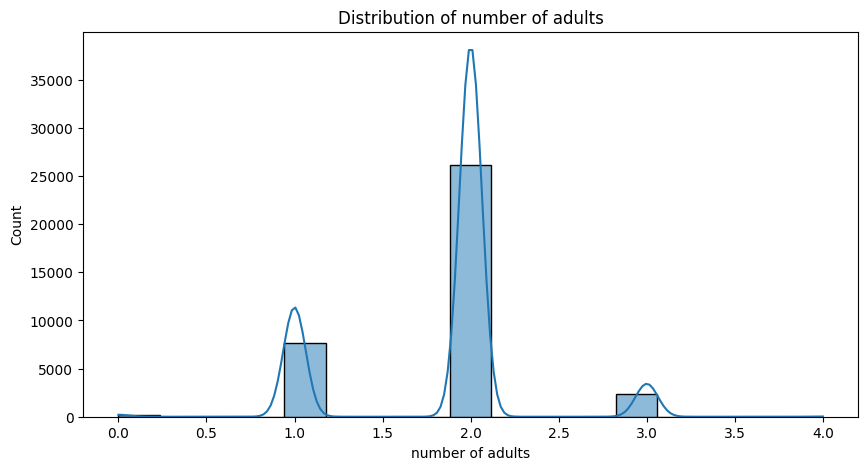

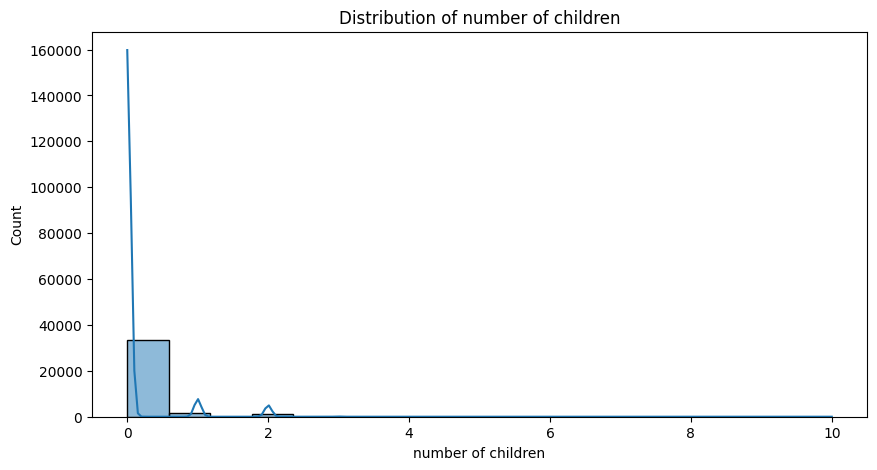

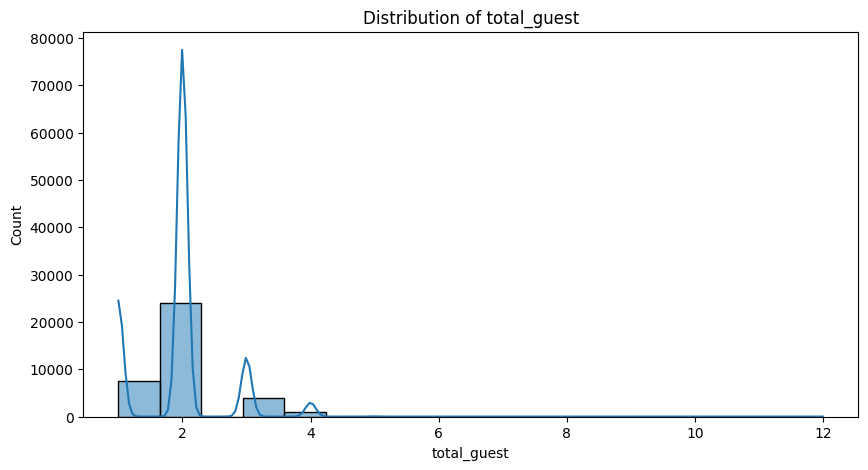

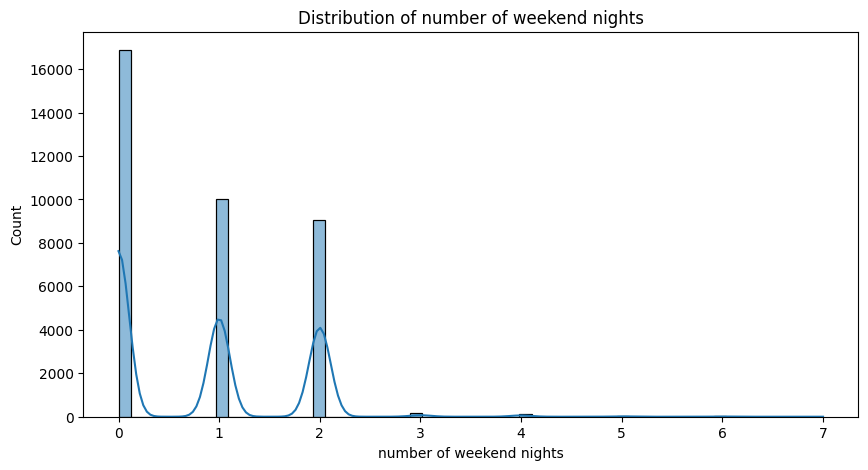

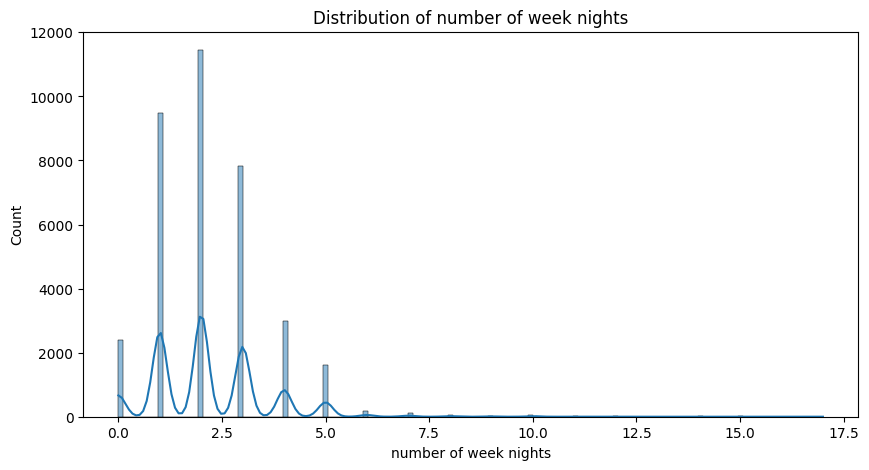

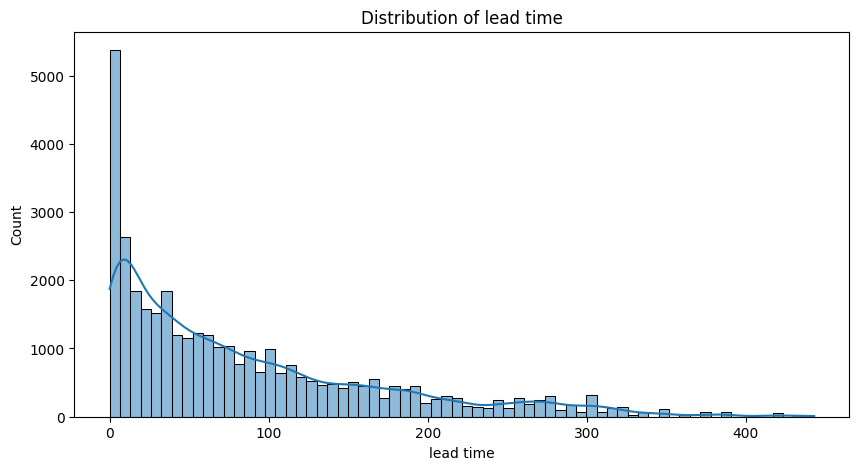

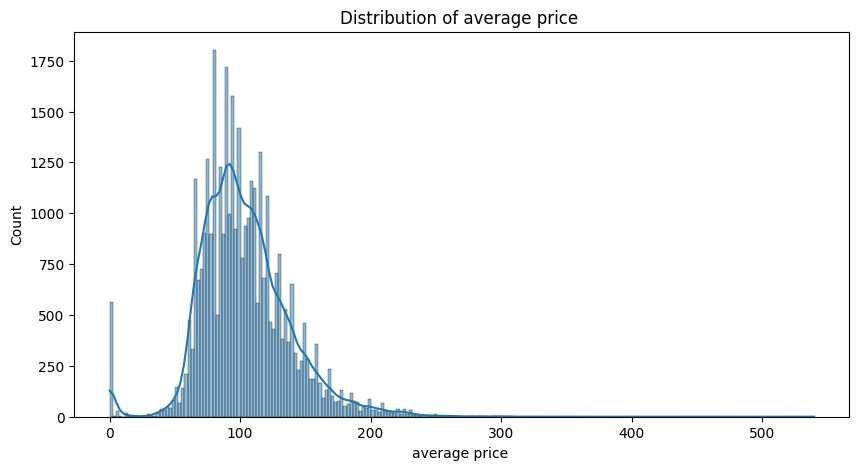

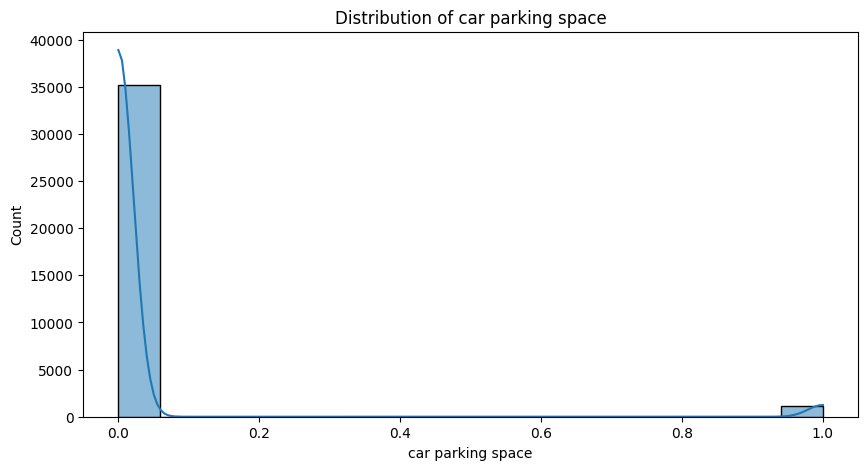

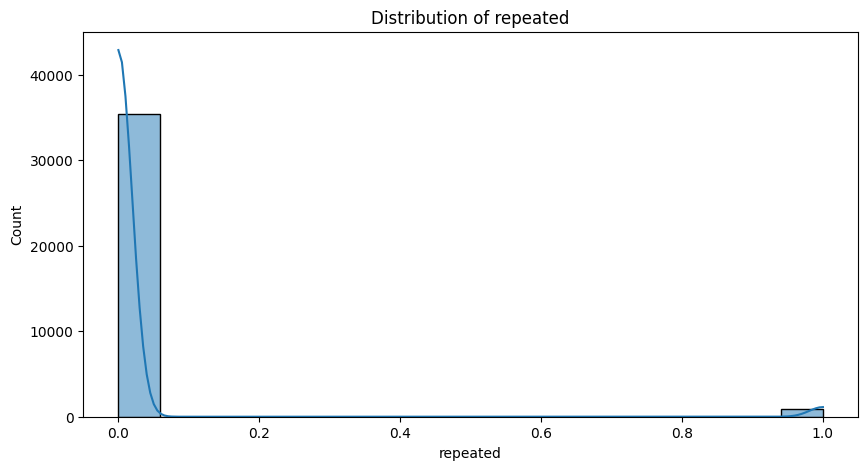

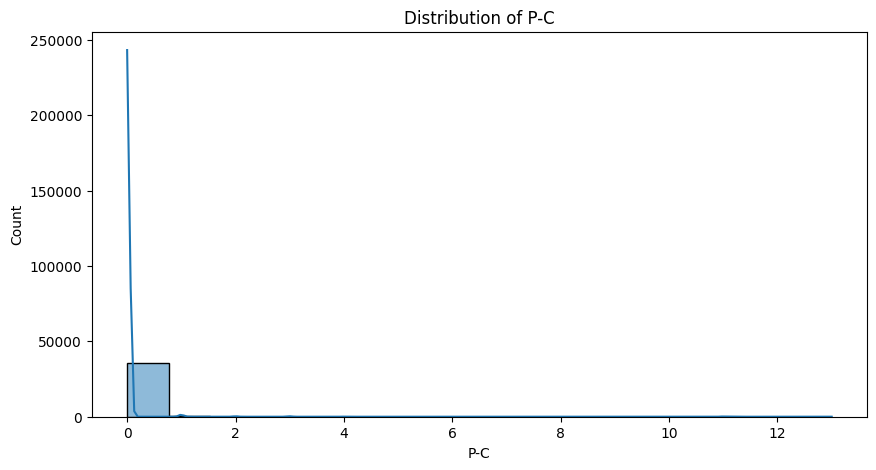

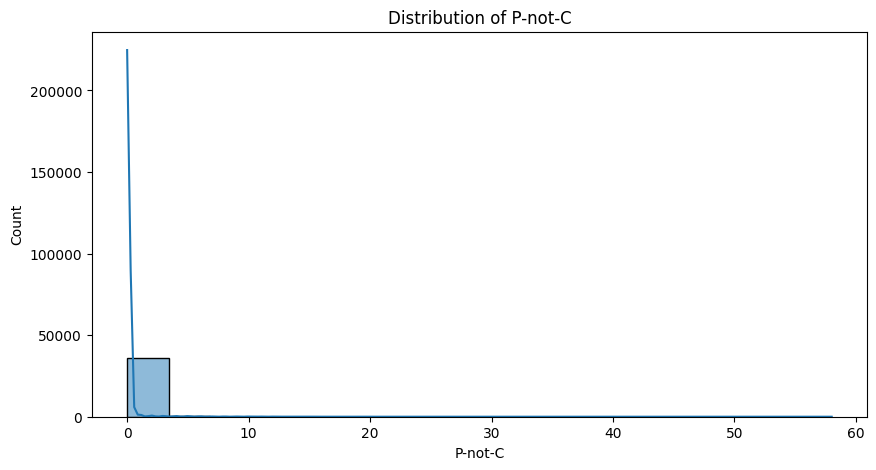

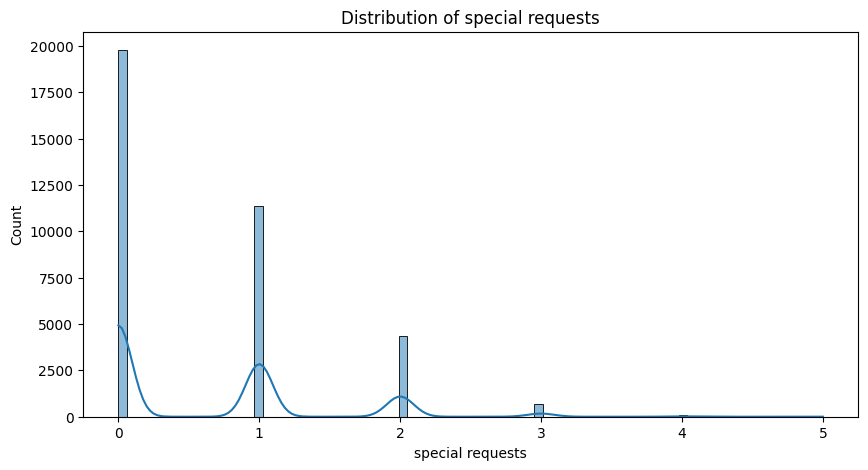

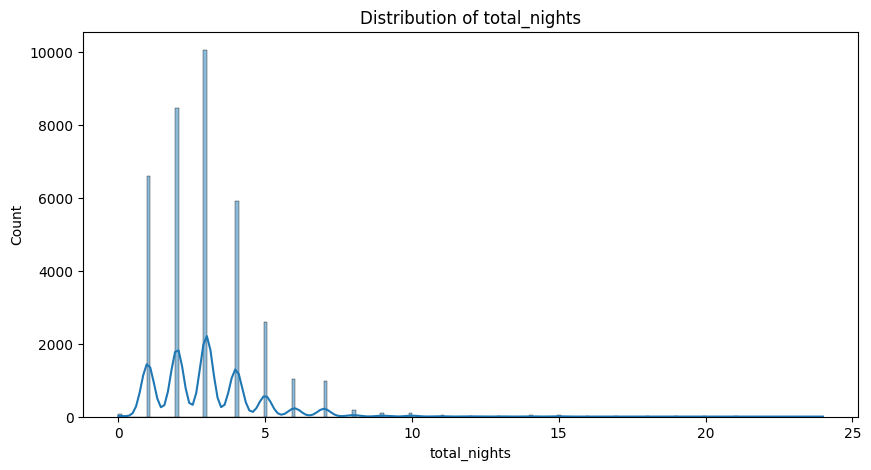

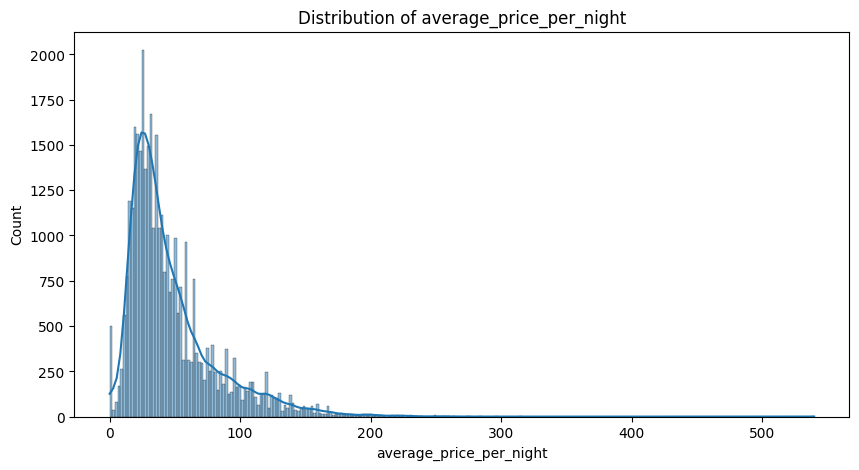

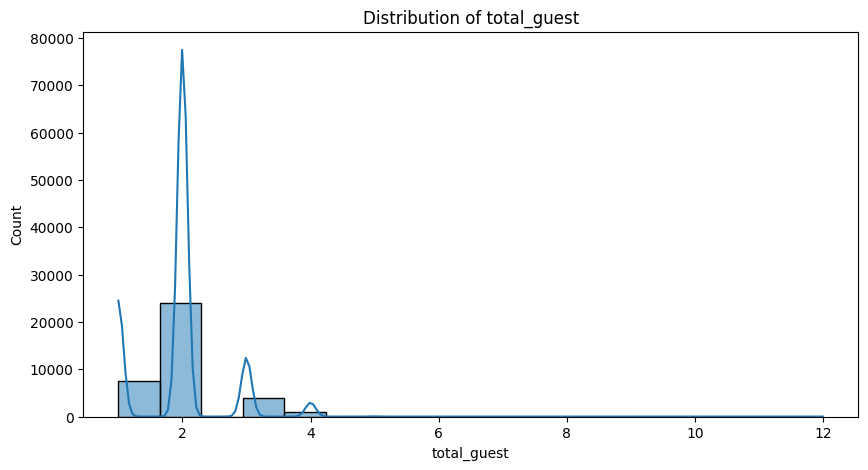

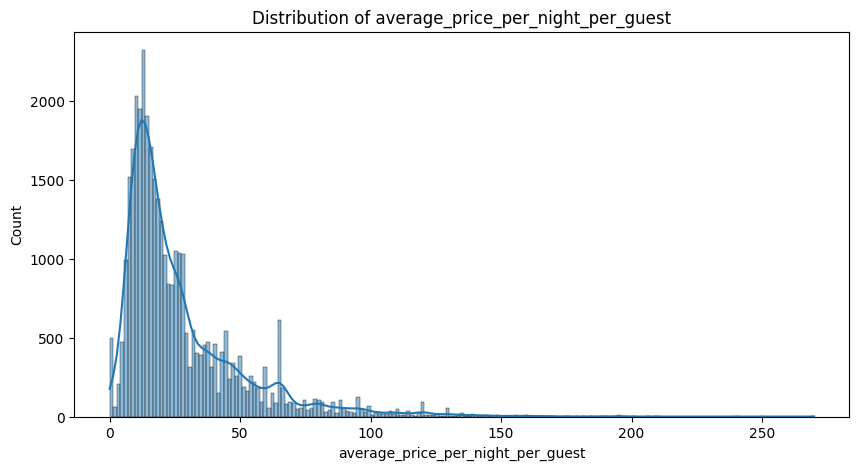

In [14]:
for feature in num_features:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()
    print()

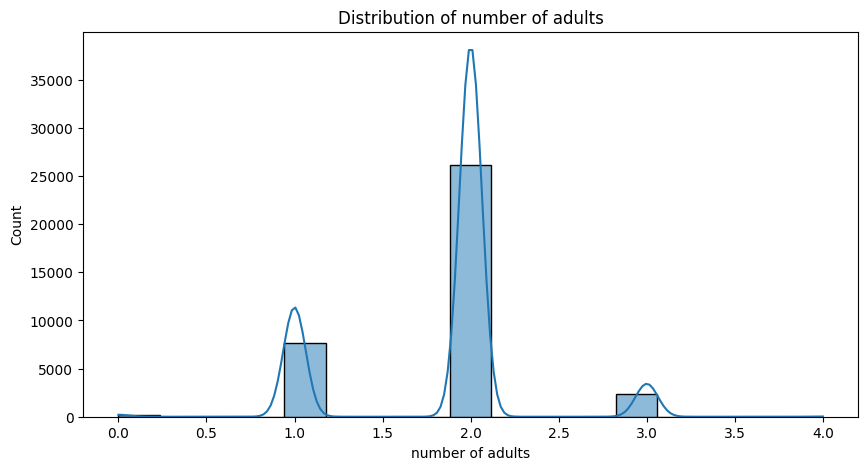

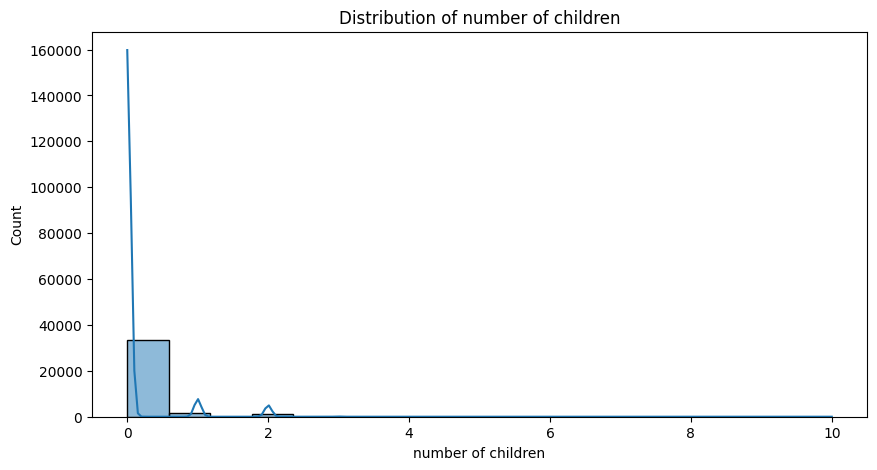

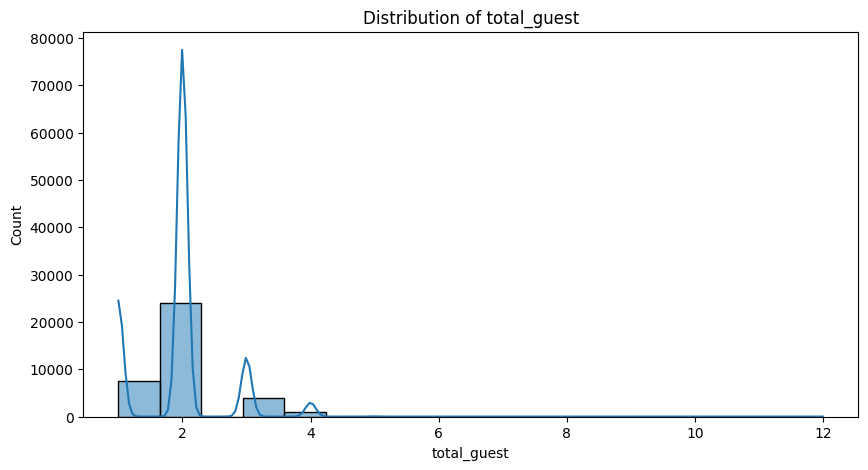

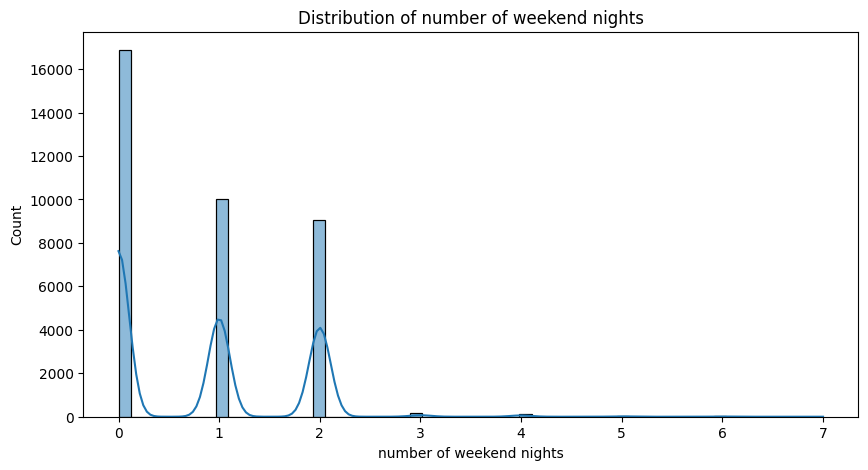

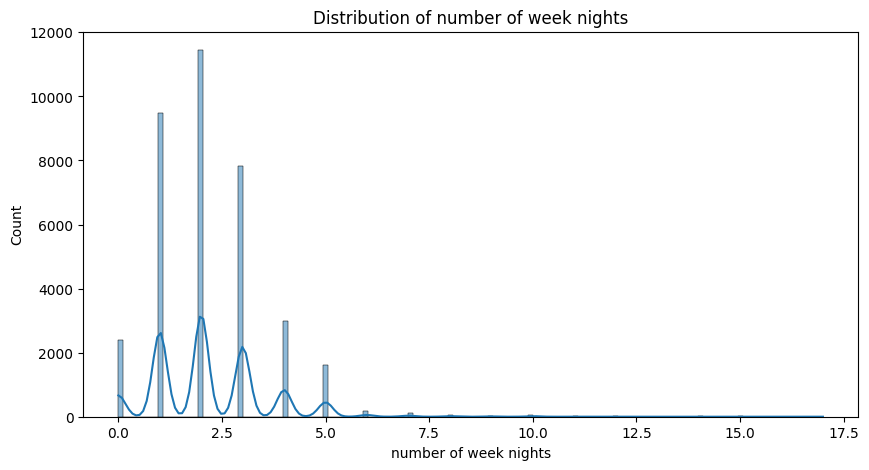

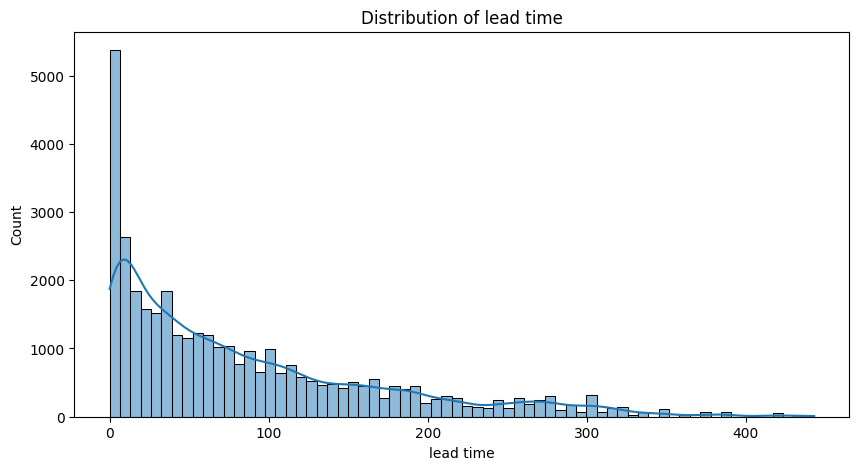

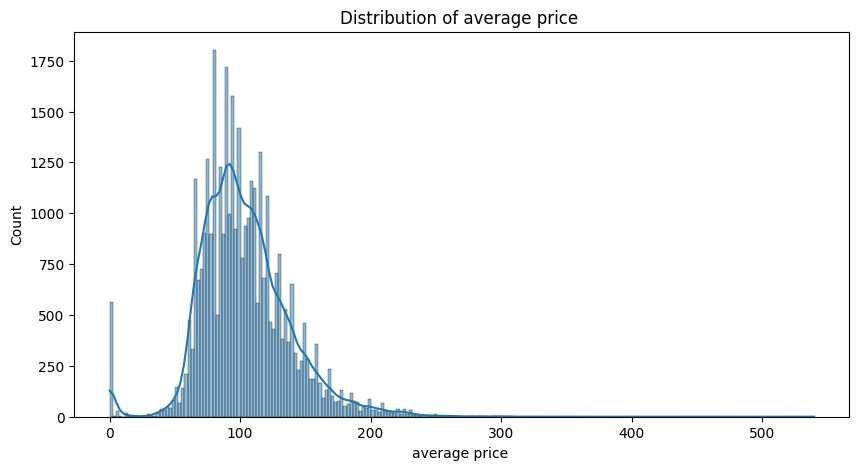

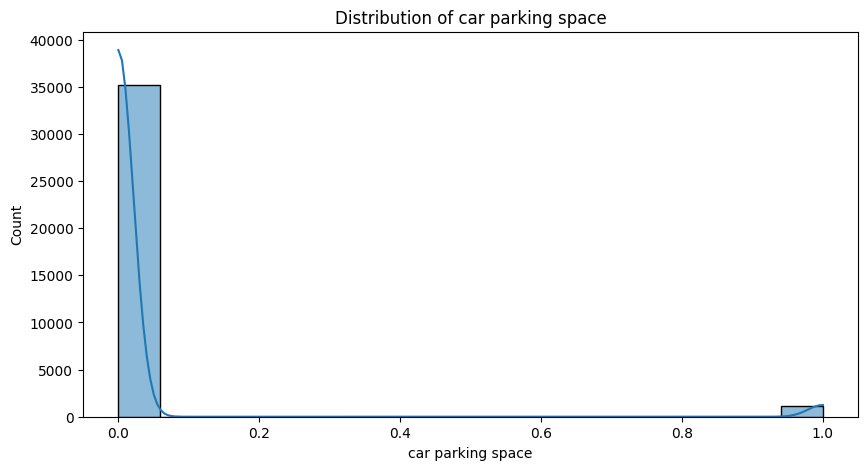

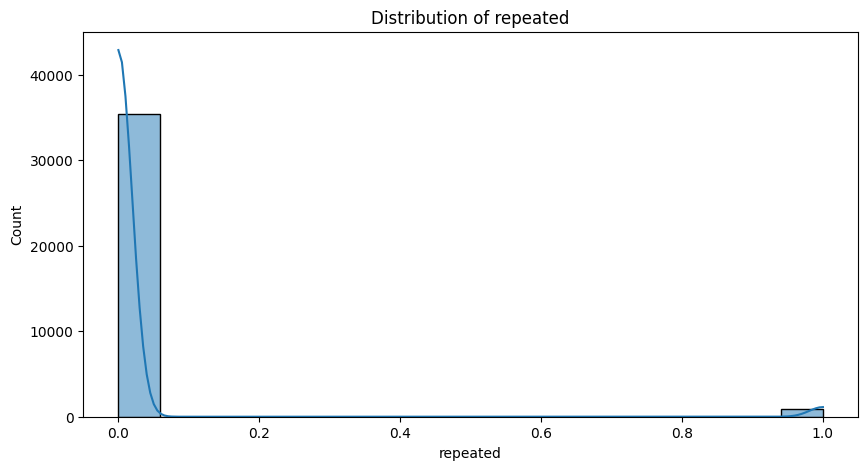

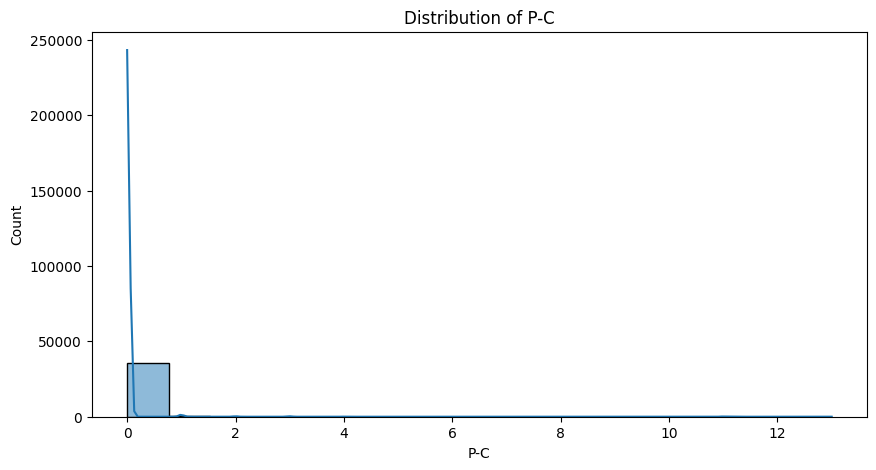

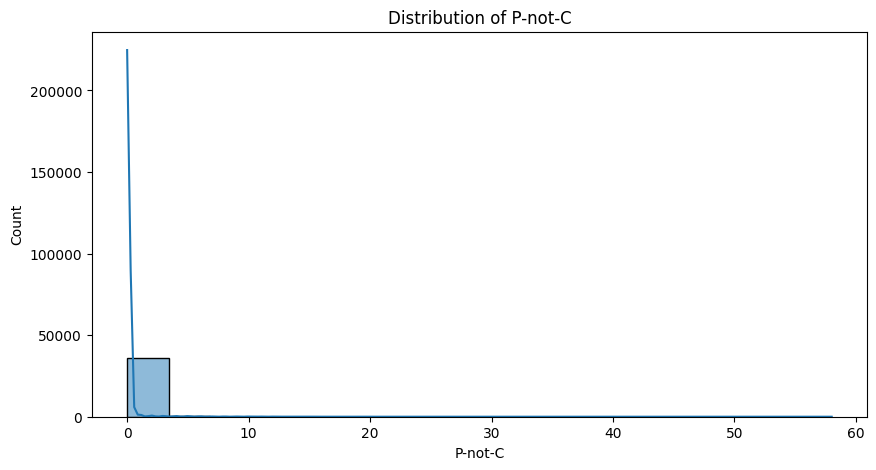

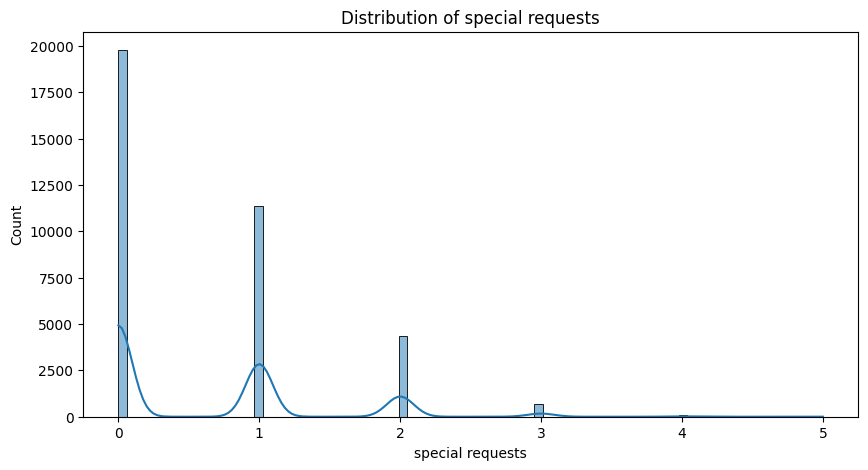

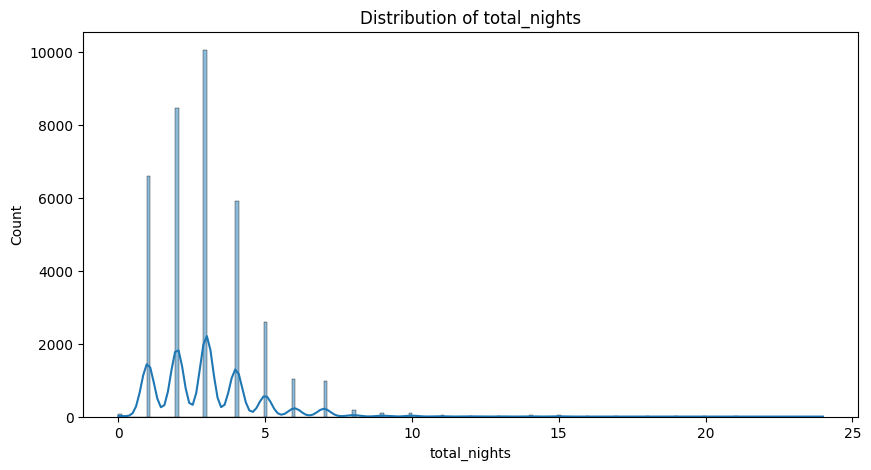

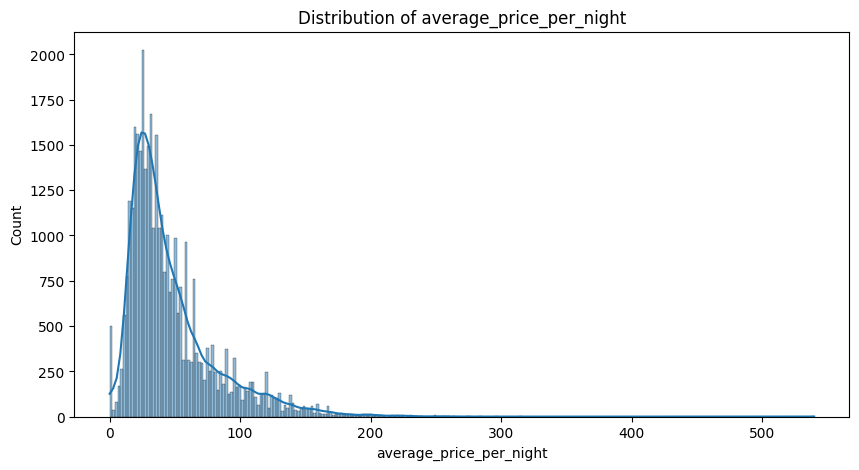

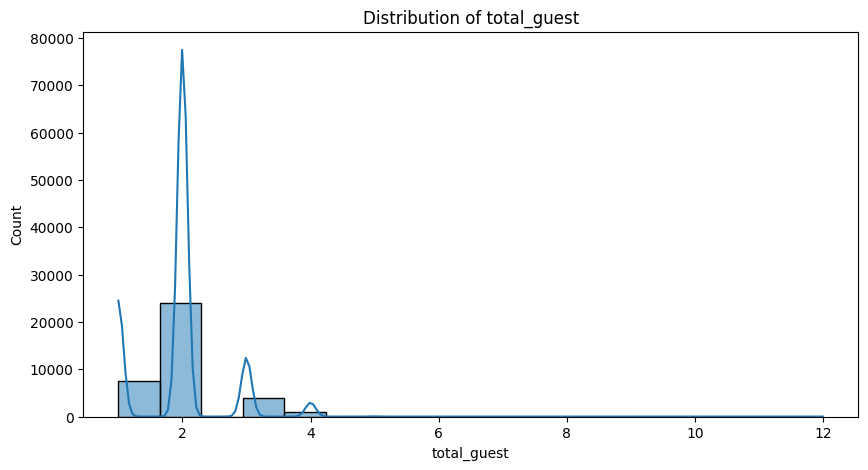

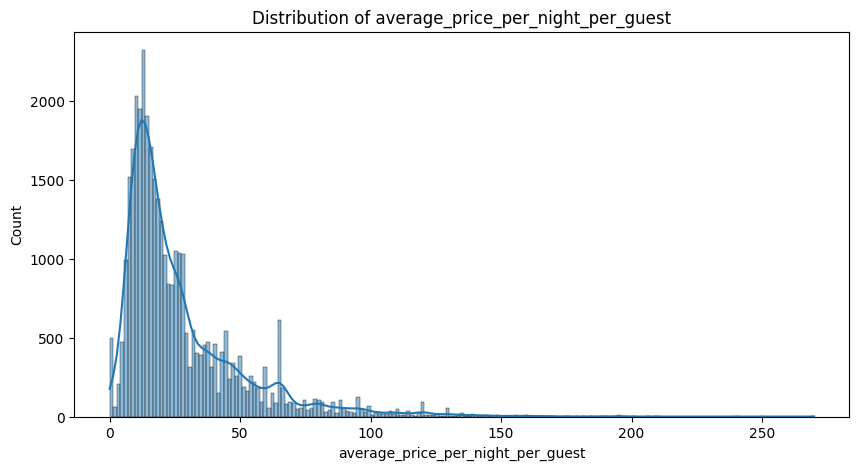

In [15]:
for feature in num_features:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()
    print()

### Check Outlier

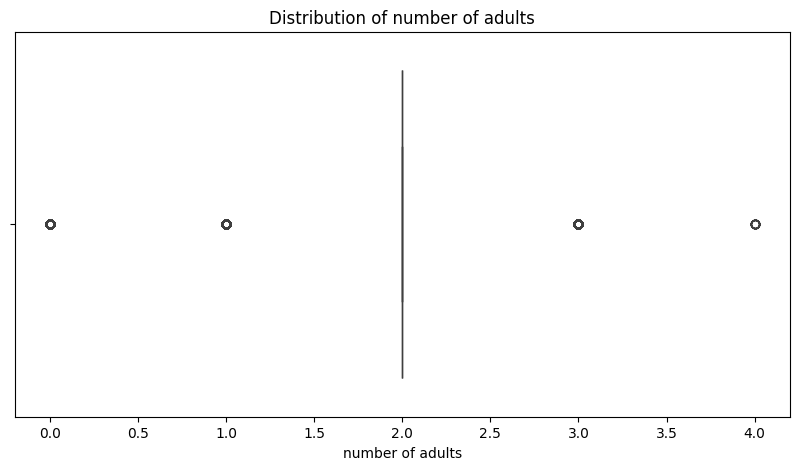

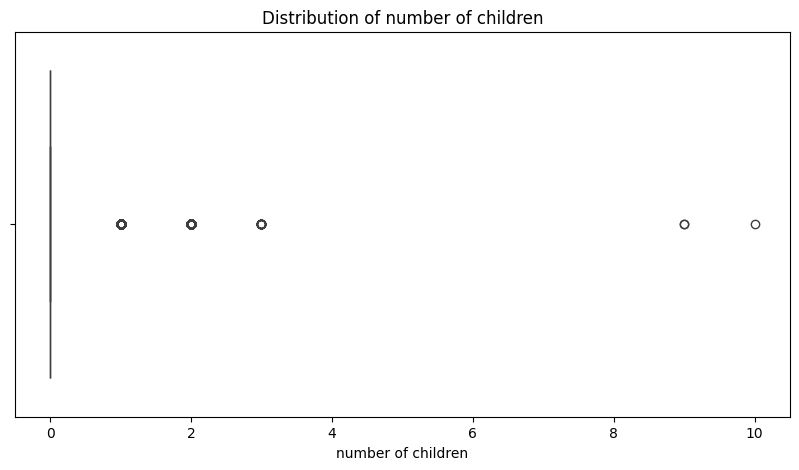

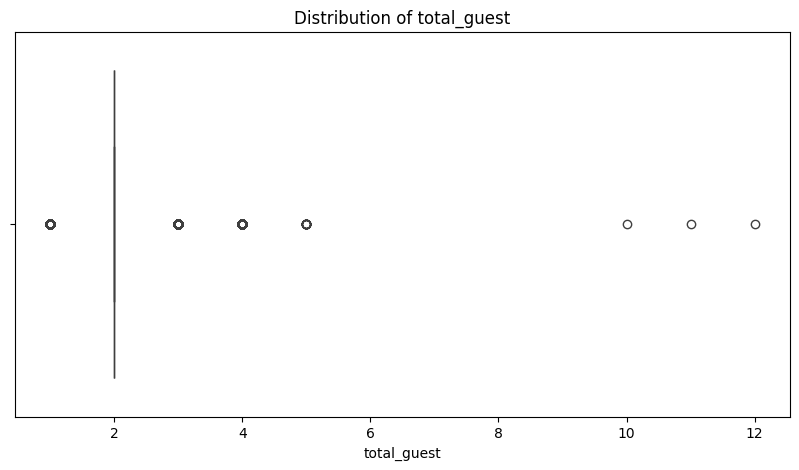

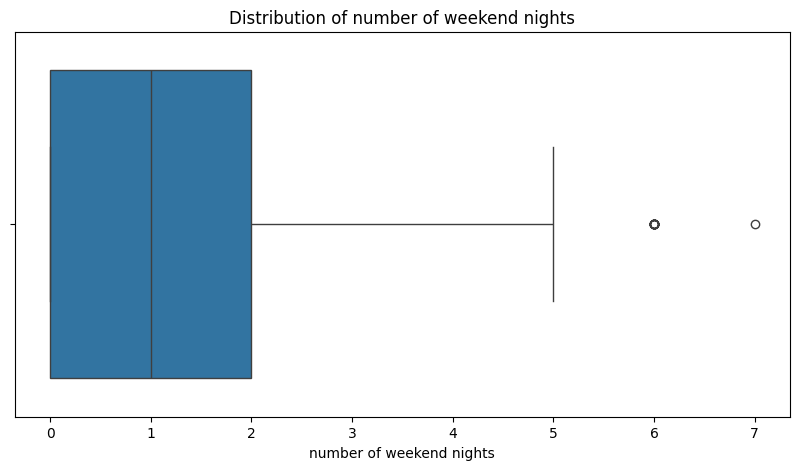

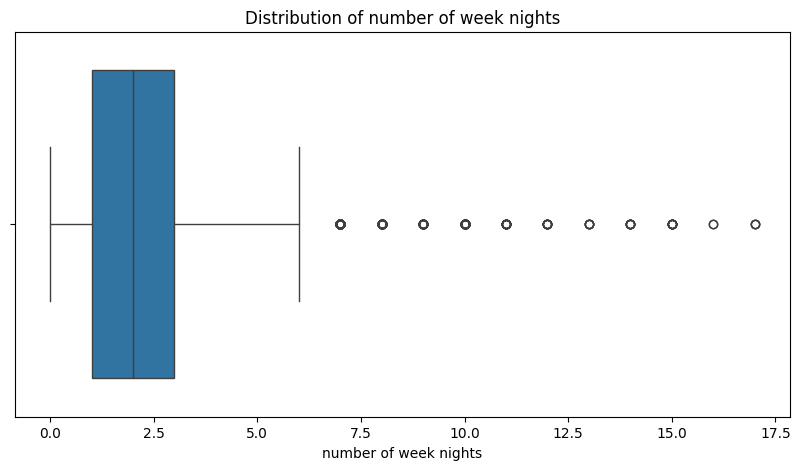

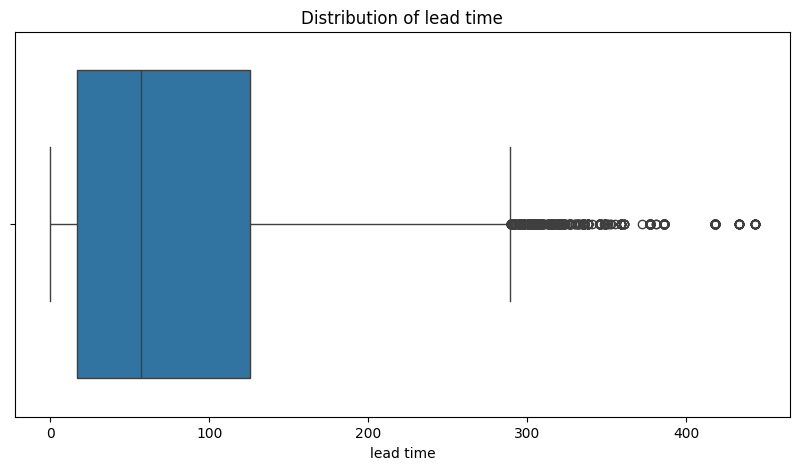

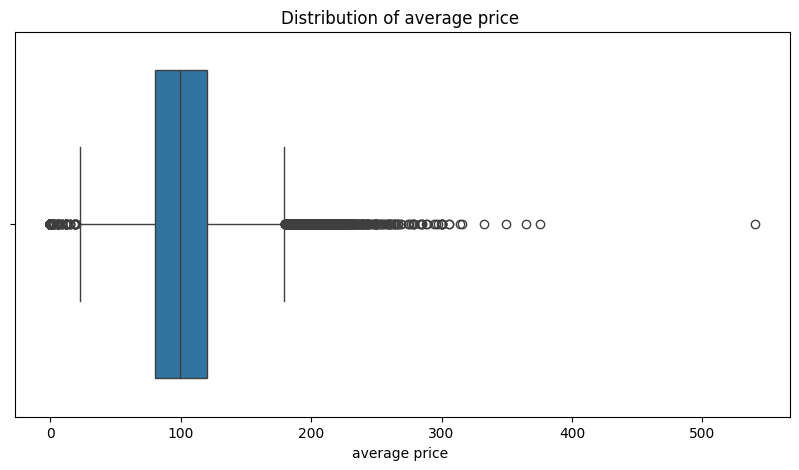

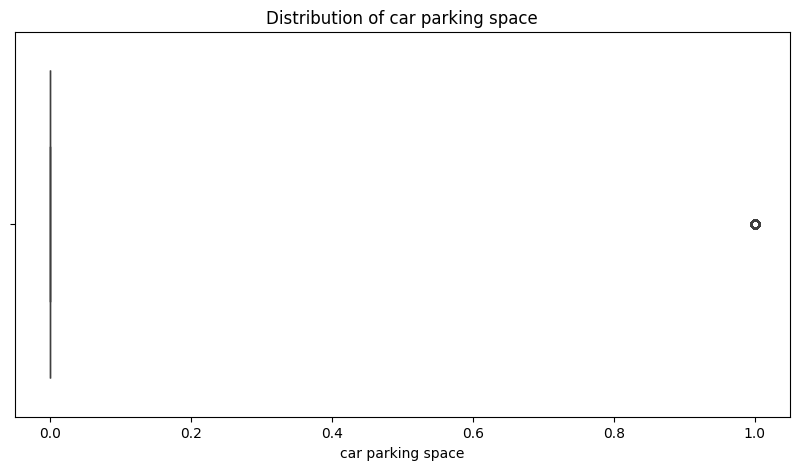

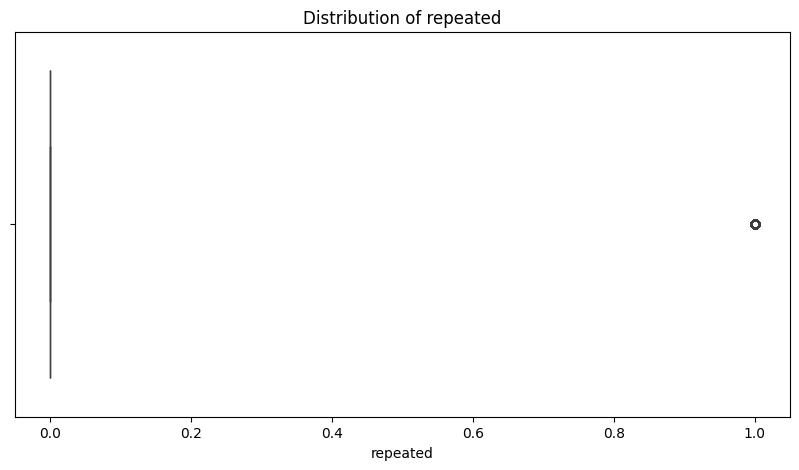

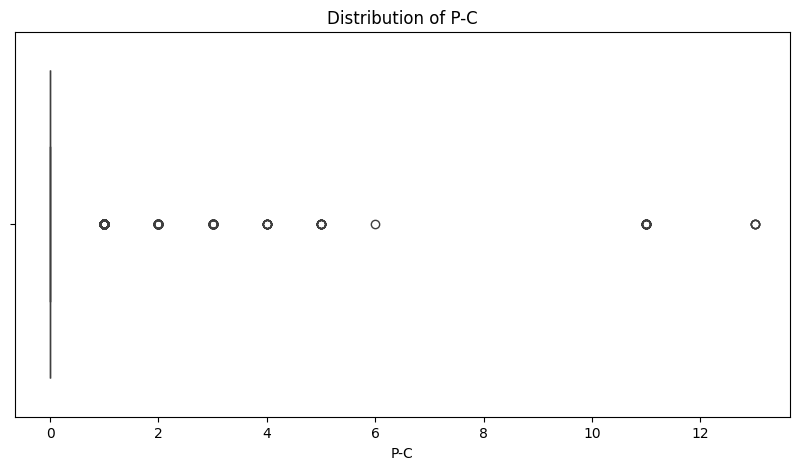

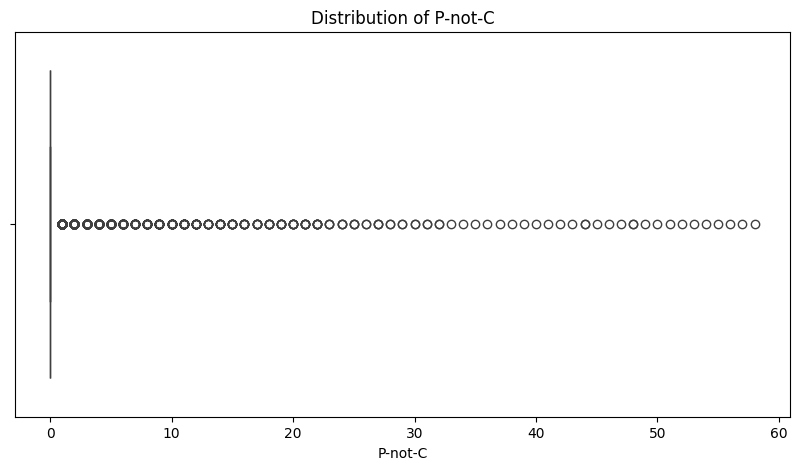

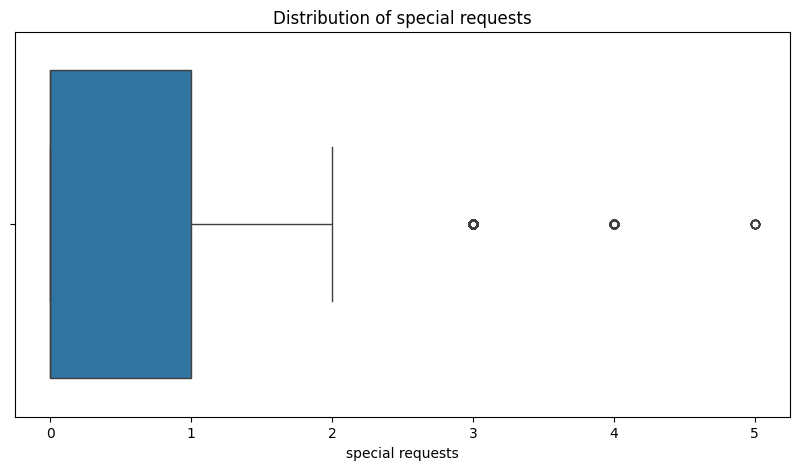

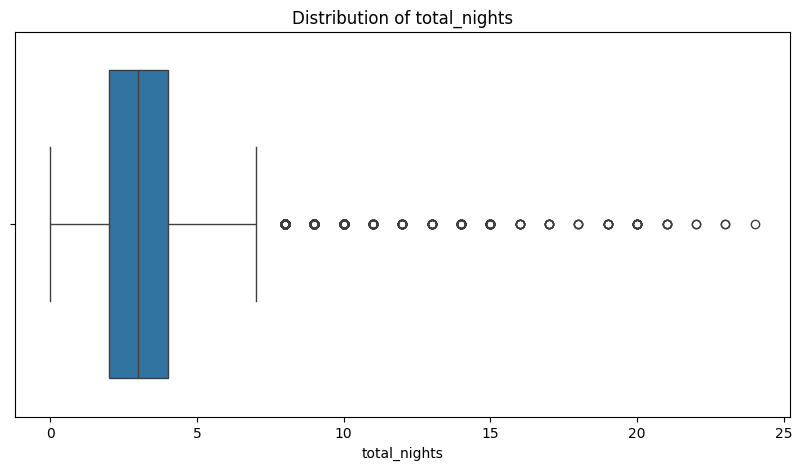

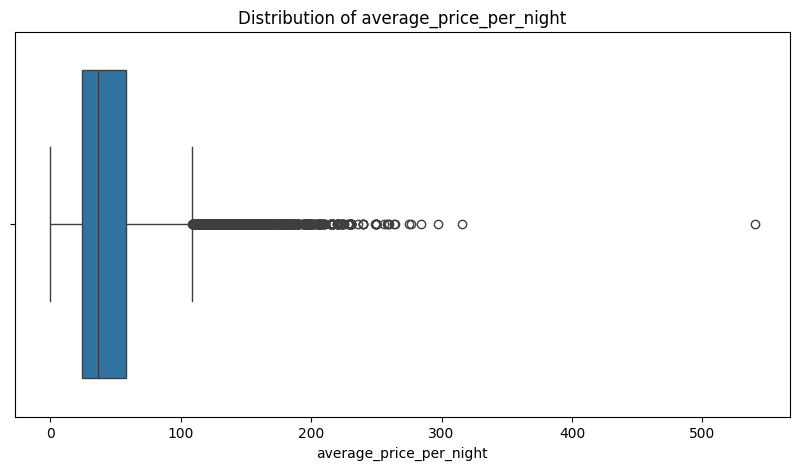

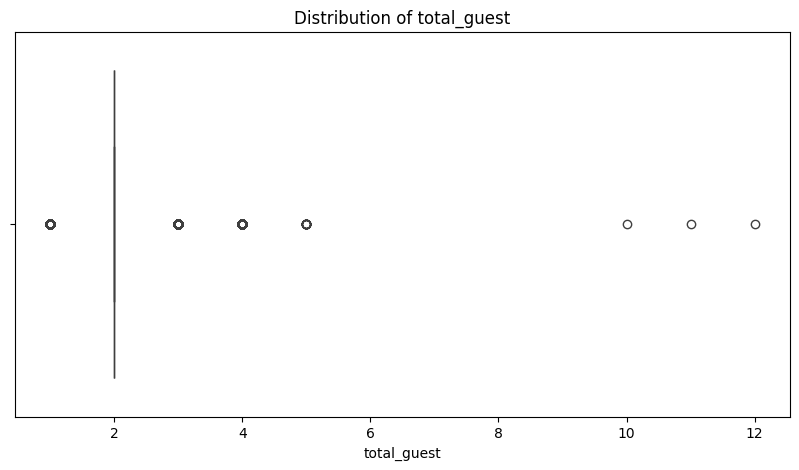

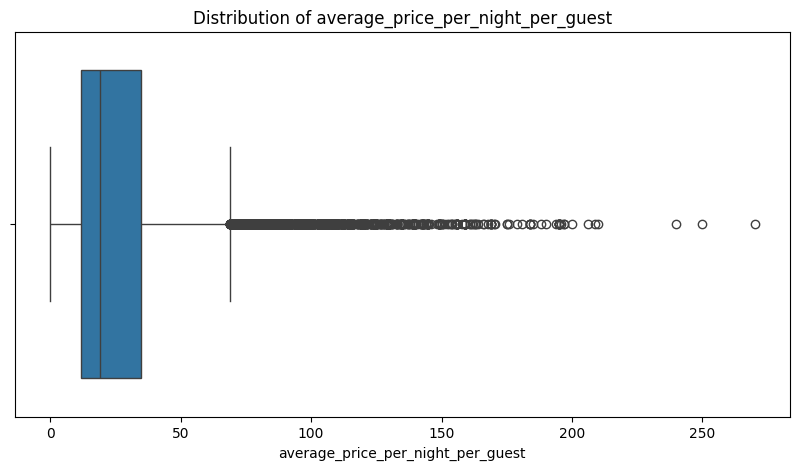

In [16]:
for feature in num_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df[feature])
    plt.title(f'Distribution of {feature}')
    plt.show()
    print()

### Outlier Handling

In [17]:
def outlier_treatment(df:pd.DataFrame, features_name: list)->pd.DataFrame:
    upper_lower = joblib.load('/content/drive/MyDrive/dict/upper_lower.pkl')
    for feature in features_name:
        lower_bound = upper_lower['lower_bound'][feature]
        upper_bound = upper_lower['upper_bound'][feature]
        df[feature][(df[feature] < lower_bound)] = lower_bound
        df[feature][(df[feature] > upper_bound)] = upper_bound
    return df

In [18]:
outlier_features = ['lead time', 'special requests', 'total_nights', 'average_price_per_night_per_guest']
upper_lower = {'upper_bound':{}, 'lower_bound': {}}
for feature in outlier_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    upper_lower['lower_bound'][feature] = lower_bound
    upper_lower['upper_bound'][feature] = upper_bound

upper_lower

{'upper_bound': {'lead time': 289.5,
  'special requests': 2.5,
  'total_nights': 7.0,
  'average_price_per_night_per_guest': 68.94749999999999},
 'lower_bound': {'lead time': -146.5,
  'special requests': -1.5,
  'total_nights': -1.0,
  'average_price_per_night_per_guest': -22.112499999999994}}

#### Save The Dictionary

In [19]:
os.makedirs('/content/drive/MyDrive/dict', exist_ok=True)
joblib.dump(upper_lower, '/content/drive/MyDrive/dict/upper_lower.pkl')

['/content/drive/MyDrive/dict/upper_lower.pkl']

In [20]:
df = outlier_treatment(df, outlier_features)

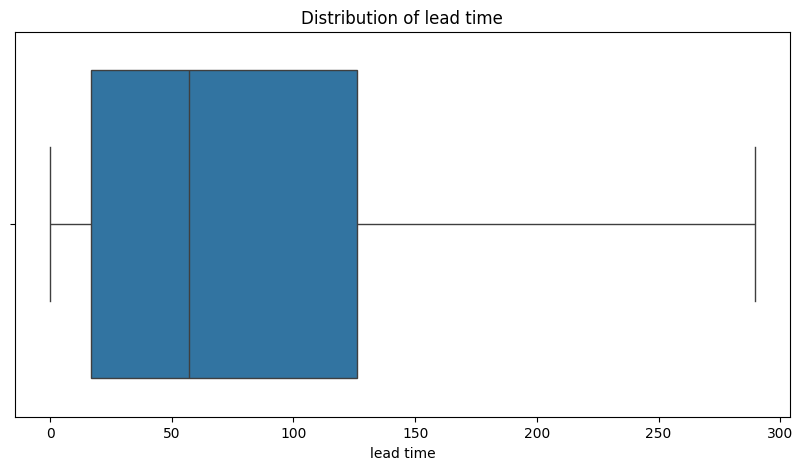

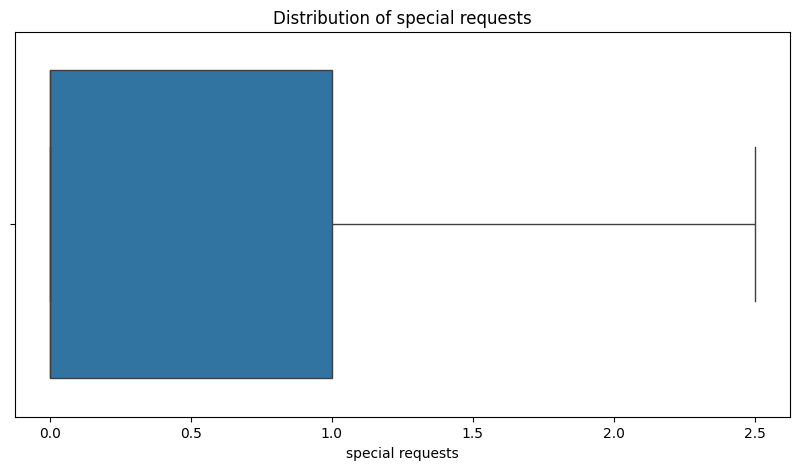

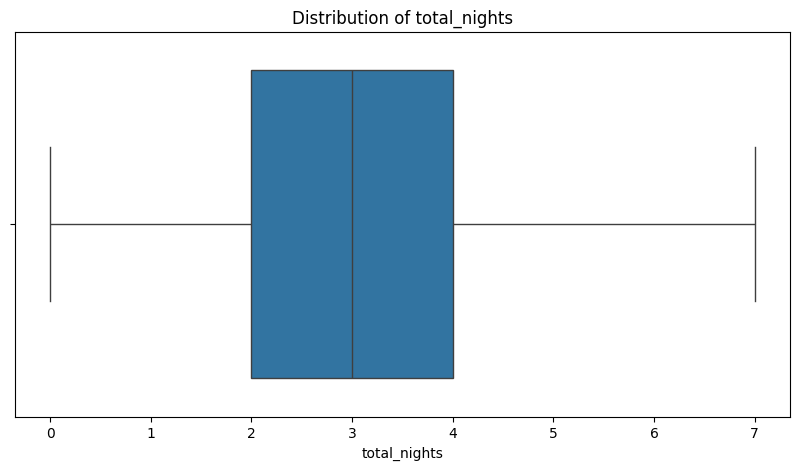

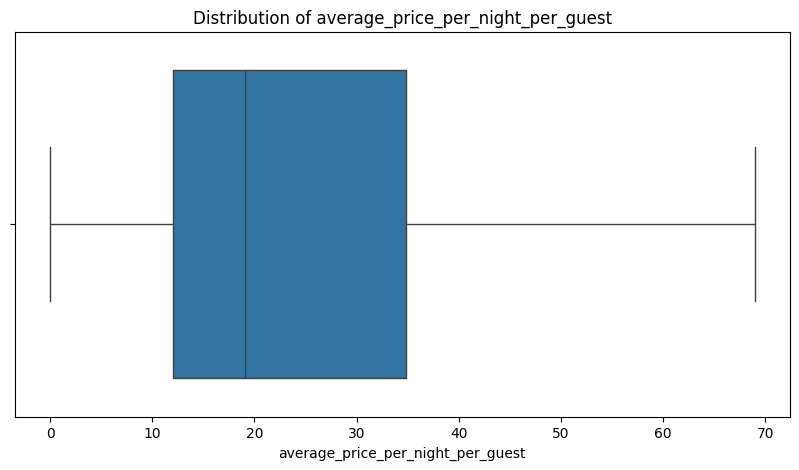

In [21]:
for feature in outlier_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df[feature])
    plt.title(f'Distribution of {feature}')
    plt.show()
    print()

## Step 4: Features Selection

In [22]:
def num_feature_selection(df: pd.DataFrame)->pd.DataFrame:
    selected_features = ['total_nights', 'average_price_per_night_per_guest',
                         'total_guest', 'lead time', 'special requests',
                         'P-C', 'P-not-C', 'repeated', 'car parking space']
    return df[selected_features]

##Step 5: Data Spliting

### Read The Data again

In [23]:
df = pd.read_csv(data_path)
df.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


### Split Data to Target and Features

In [24]:
X, y = df.drop('booking status', axis=1), df['booking status']

### Transfrom Target to Numeric

In [25]:
target_map = {
    'Canceled': 0,
    'Not_Canceled': 1
}
y = y.map(target_map)

### Split Data to Train and Test

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((29028, 16), (7257, 16), (29028,), (7257,))

In [27]:
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)
X_train.shape, y_train.shape

((39082, 16), (39082,))

In [28]:
y_train.value_counts()

,count
booking status,
0,19541
1,19541


## Step 6: Design Data Pipeline

In [29]:
num_features = ['number of adults', 'number of children', 'number of weekend nights',
                'number of week nights', 'lead time', 'average price ', 'car parking space',
                'repeated', 'P-C', 'P-not-C', 'special requests']

cat_features = ['room type', 'type of meal', 'market segment type']

### Design Numeric Pipeline

In [30]:
num_pipeline = Pipeline([
    ('Features Engineering', FunctionTransformer(feature_engineering)),
    ('Outlier Treatment', FunctionTransformer(outlier_treatment, kw_args={'features_name': outlier_features})),
    ('Numerical Feature Selection', FunctionTransformer(num_feature_selection)),
    ('Imputer', SimpleImputer(strategy='median')),
    ('Scaler', StandardScaler())
])
num_pipeline

Pipeline(steps=[('Features Engineering',
                 FunctionTransformer(func=<function feature_engineering at 0x7f2a8e3617e0>)),
                ('Outlier Treatment',
                 FunctionTransformer(func=<function outlier_treatment at 0x7f2a87fc1b40>,
                                     kw_args={'features_name': ['lead time',
                                                                'special '
                                                                'requests',
                                                                'total_nights',
                                                                'average_price_per_night_per_guest']})),
                ('Numerical Feature Selection',
                 FunctionTransformer(func=<function num_feature_selection at 0x7f2a87d51f30>)),
                ('Imputer', SimpleImputer(strategy='median')),
                ('Scaler', StandardScaler())])

### Design Categorical Pipeline

In [31]:
cat_pipeline = Pipeline([
    ('Imputer', SimpleImputer(strategy='most_frequent')),
    ('Encoder', OneHotEncoder(handle_unknown='ignore'))
])
cat_pipeline

Pipeline(steps=[('Imputer', SimpleImputer(strategy='most_frequent')),
                ('Encoder', OneHotEncoder(handle_unknown='ignore'))])

### Design The Full Pipeline

In [32]:
full_pipline = ColumnTransformer([
    ('Numerical Pipeline', num_pipeline, num_features),
    ('Categorical Pipeline', cat_pipeline, cat_features),
])
full_pipline

ColumnTransformer(transformers=[('Numerical Pipeline',
                                 Pipeline(steps=[('Features Engineering',
                                                  FunctionTransformer(func=<function feature_engineering at 0x7f2a8e3617e0>)),
                                                 ('Outlier Treatment',
                                                  FunctionTransformer(func=<function outlier_treatment at 0x7f2a87fc1b40>,
                                                                      kw_args={'features_name': ['lead '
                                                                                                 'time',
                                                                                                 'special '
                                                                                                 'requests',
                                                                                                 'total_nights',
                                                                                                 'average_price_per_nig...
                                 ['number of adults', 'number of children',
                                  'number of weekend nights',
                                  'number of week nights', 'lead time',
                                  'average price ', 'car parking space',
                                  'repeated', 'P-C', 'P-not-C',
                                  'special requests']),
                                ('Categorical Pipeline',
                                 Pipeline(steps=[('Imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('Encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['room type', 'type of meal',
                                  'market segment type'])])

### Transfrom The Training Data

In [33]:
X_train_transformed = full_pipline.fit_transform(X_train)
X_train_transformed.shape

(39082, 25)

## Step 7: Model Selection

### Logistic Regression Classifier

In [34]:
lg_clf = LogisticRegression()
cross_val_score(lg_clf, X_train_transformed, y_train, cv=5, scoring='accuracy').mean()

0.772401642406277

### K-Neighbors Classifier

In [35]:
knn_clf = KNeighborsClassifier(n_neighbors=10)
cross_val_score(knn_clf, X_train_transformed, y_train, cv=5, scoring='accuracy').mean()

0.8327876977047506

### SVM Classifier

In [36]:
svm_clf = SVC()
cross_val_score(svm_clf, X_train_transformed, y_train, cv=5, scoring='accuracy').mean()

0.7933575243259677

### Naive Bayes Classifier

In [37]:
nb_clf = GaussianNB()
cross_val_score(nb_clf, X_train_transformed, y_train, cv=5, scoring='accuracy').mean()

0.5518141149469656

### Decision Tree Classifier

In [38]:
dt_clf = DecisionTreeClassifier()
cross_val_score(dt_clf, X_train_transformed, y_train, cv=5, scoring='accuracy').mean()

0.9050209245288429

### Random Forest Classifier

In [39]:
rf_clf = RandomForestClassifier()
cross_val_score(rf_clf, X_train_transformed, y_train, cv=5, scoring='accuracy').mean()

0.9175329560838259

### Hyper Pramater Tuning for Random Forest Classifier

In [40]:
rf_clf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [200, 100, 70, 50],
    'max_depth': [None, 10, 5, 3, 1],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4, 8],
}
grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 5, 3, 1],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 5],
                         'n_estimators': [200, 100, 70, 50]},
             scoring='accuracy')

In [41]:
grid_search.best_score_

0.9178399956057245

In [42]:
grid_search.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

### Hyper Pramater Tuning for Decision Tree Classifier

In [43]:
rf_clf = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [None, 10, 5, 3, 1],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8, 16],
}
grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 5, 3, 1],
                         'min_samples_leaf': [1, 2, 4, 8, 16],
                         'min_samples_split': [2, 5, 10, 15, 20]},
             scoring='accuracy')

In [44]:
grid_search.best_score_

0.9048930473161072

In [45]:
grid_search.best_params_

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

### Neural Networks Classifier

In [46]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_transformed.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,417 (17.25 KB)

 Trainable params: 4,417 (17.25 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
hist = model.fit(X_train_transformed, y_train, epochs=100, validation_split=0.2, batch_size=32)

Epoch 1/100
978/978 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7670 - loss: 0.4851 - val_accuracy: 0.8085 - val_loss: 0.4215
Epoch 2/100
978/978 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8043 - loss: 0.4255 - val_accuracy: 0.6774 - val_loss: 0.6480
Epoch 3/100
978/978 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8102 - loss: 0.4143 - val_accuracy: 0.6674 - val_loss: 0.6486
Epoch 4/100
978/978 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8156 - loss: 0.4063 - val_accuracy: 0.6833 - val_loss: 0.6154
Epoch 5/100
978/978 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8200 - loss: 0.3954 - val_accuracy: 0.6994 - val_loss: 0.5773
Epoch 6/100
978/978 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8217 - loss: 0.3912 - val_accuracy: 0.7481 - val_loss: 0.5015
Epoch 7/100
978/978 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8220 - loss: 0.3891 - val_accuracy: 0.7279 - val_loss: 0.5322
Epoch 8/100
978/978 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8224 - loss: 0.3820 - val_accu

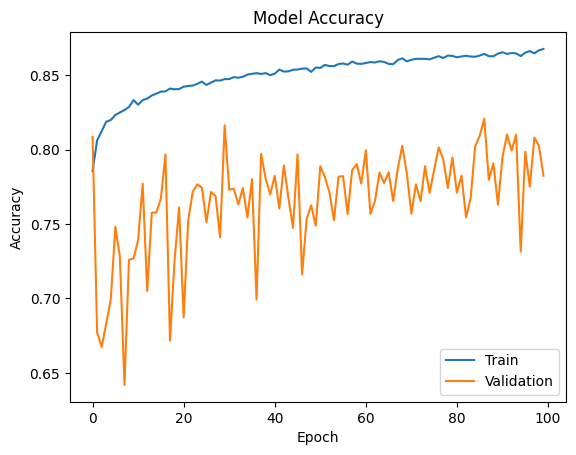

In [49]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

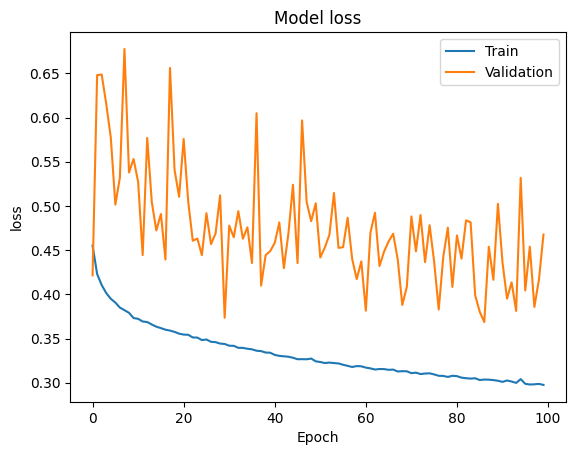

In [50]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Selected Modles are Decision Tree, Random Forest, and Neural Networks

## Step 8: Design The Selected Model Pipeline

### Training Data overview

In [51]:
X_train.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation
0,INN00388,3,0,1,3,Meal Plan 1,0,Room_Type 4,155,Online,0,0,0,115.6,1,12/26/2018
1,INN07769,1,0,2,2,Meal Plan 1,0,Room_Type 4,48,Online,0,0,0,149.4,0,9/18/2018
2,INN11793,2,0,1,2,Meal Plan 1,0,Room_Type 1,305,Offline,0,0,0,89.0,0,11/4/2018
3,INN07979,1,0,0,2,Meal Plan 1,0,Room_Type 1,102,Online,0,0,0,86.4,2,12/6/2018
4,INN10671,2,2,1,2,Meal Plan 1,0,Room_Type 6,9,Online,0,0,0,221.0,0,6/10/2018


### Decision Tree

In [52]:
DT_model = Pipeline([
    ('Full Data Pipeline', full_pipline),
    ('Model', DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2))
])
DT_model

Pipeline(steps=[('Full Data Pipeline',
                 ColumnTransformer(transformers=[('Numerical Pipeline',
                                                  Pipeline(steps=[('Features '
                                                                   'Engineering',
                                                                   FunctionTransformer(func=<function feature_engineering at 0x7f2a8e3617e0>)),
                                                                  ('Outlier '
                                                                   'Treatment',
                                                                   FunctionTransformer(func=<function outlier_treatment at 0x7f2a87fc1b40>,
                                                                                       kw_args={'features_name': ['lead '
                                                                                                                  'time',
                                                                                                                  'special '
                                                                                                                  'request...
                                                   'number of weekend nights',
                                                   'number of week nights',
                                                   'lead time',
                                                   'average price ',
                                                   'car parking space',
                                                   'repeated', 'P-C', 'P-not-C',
                                                   'special requests']),
                                                 ('Categorical Pipeline',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['room type', 'type of meal',
                                                   'market segment type'])])),
                ('Model', DecisionTreeClassifier())])

In [53]:
DT_model.fit(X_train, y_train)

Pipeline(steps=[('Full Data Pipeline',
                 ColumnTransformer(transformers=[('Numerical Pipeline',
                                                  Pipeline(steps=[('Features '
                                                                   'Engineering',
                                                                   FunctionTransformer(func=<function feature_engineering at 0x7f2a8e3617e0>)),
                                                                  ('Outlier '
                                                                   'Treatment',
                                                                   FunctionTransformer(func=<function outlier_treatment at 0x7f2a87fc1b40>,
                                                                                       kw_args={'features_name': ['lead '
                                                                                                                  'time',
                                                                                                                  'special '
                                                                                                                  'request...
                                                   'number of weekend nights',
                                                   'number of week nights',
                                                   'lead time',
                                                   'average price ',
                                                   'car parking space',
                                                   'repeated', 'P-C', 'P-not-C',
                                                   'special requests']),
                                                 ('Categorical Pipeline',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['room type', 'type of meal',
                                                   'market segment type'])])),
                ('Model', DecisionTreeClassifier())])

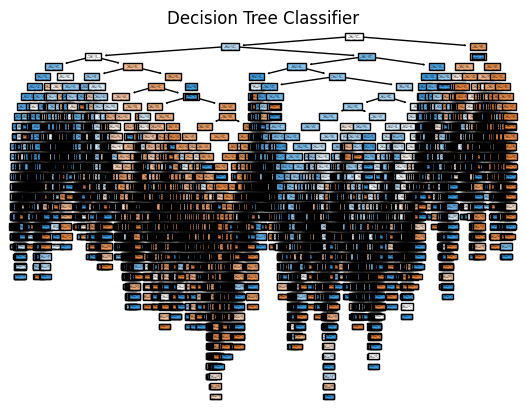

In [54]:
plot_tree(DT_model.named_steps['Model'], filled=True)
plt.title('Decision Tree Classifier')
plt.show()

In [55]:
y_pred = DT_model.predict(X_test)
dt_clf_report = classification_report(y_test, y_pred)
print(dt_clf_report)

              precision    recall  f1-score   support

           0       0.75      0.76      0.75      2402
           1       0.88      0.87      0.88      4855

    accuracy                           0.83      7257
   macro avg       0.81      0.82      0.81      7257
weighted avg       0.84      0.83      0.84      7257



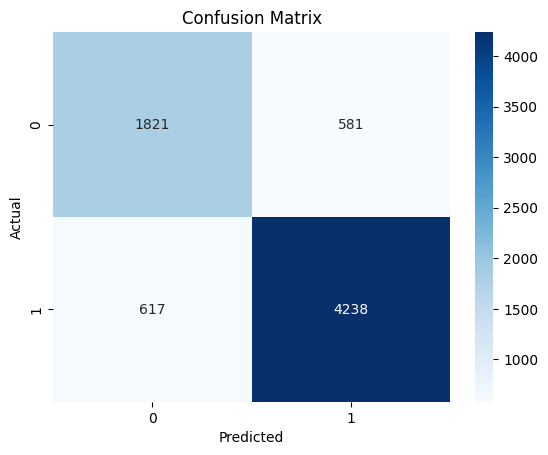

In [56]:
dt_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Random Forest

In [57]:
RF_model = Pipeline([
    ('Full Data Pipeline', full_pipline),
    ('Model', RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_leaf=2, min_samples_split=2))
])
RF_model

Pipeline(steps=[('Full Data Pipeline',
                 ColumnTransformer(transformers=[('Numerical Pipeline',
                                                  Pipeline(steps=[('Features '
                                                                   'Engineering',
                                                                   FunctionTransformer(func=<function feature_engineering at 0x7f2a8e3617e0>)),
                                                                  ('Outlier '
                                                                   'Treatment',
                                                                   FunctionTransformer(func=<function outlier_treatment at 0x7f2a87fc1b40>,
                                                                                       kw_args={'features_name': ['lead '
                                                                                                                  'time',
                                                                                                                  'special '
                                                                                                                  'request...
                                                   'lead time',
                                                   'average price ',
                                                   'car parking space',
                                                   'repeated', 'P-C', 'P-not-C',
                                                   'special requests']),
                                                 ('Categorical Pipeline',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['room type', 'type of meal',
                                                   'market segment type'])])),
                ('Model',
                 RandomForestClassifier(min_samples_leaf=2, n_estimators=200))])

In [58]:
RF_model.fit(X_train, y_train)

Pipeline(steps=[('Full Data Pipeline',
                 ColumnTransformer(transformers=[('Numerical Pipeline',
                                                  Pipeline(steps=[('Features '
                                                                   'Engineering',
                                                                   FunctionTransformer(func=<function feature_engineering at 0x7f2a8e3617e0>)),
                                                                  ('Outlier '
                                                                   'Treatment',
                                                                   FunctionTransformer(func=<function outlier_treatment at 0x7f2a87fc1b40>,
                                                                                       kw_args={'features_name': ['lead '
                                                                                                                  'time',
                                                                                                                  'special '
                                                                                                                  'request...
                                                   'lead time',
                                                   'average price ',
                                                   'car parking space',
                                                   'repeated', 'P-C', 'P-not-C',
                                                   'special requests']),
                                                 ('Categorical Pipeline',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['room type', 'type of meal',
                                                   'market segment type'])])),
                ('Model',
                 RandomForestClassifier(min_samples_leaf=2, n_estimators=200))])

In [59]:
y_pred = RF_model.predict(X_test)
rf_clf_report = classification_report(y_test, y_pred)
print(rf_clf_report)

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      2402
           1       0.91      0.90      0.90      4855

    accuracy                           0.87      7257
   macro avg       0.85      0.86      0.86      7257
weighted avg       0.87      0.87      0.87      7257



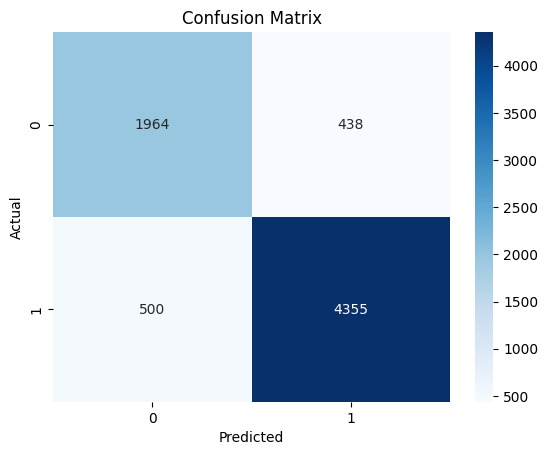

In [60]:
rf_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Neural Network Classifier

In [61]:
def create_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train_transformed.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [62]:
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
keras_clf = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping])

NN_model = Pipeline([
    ('Full Data Pipeline', full_pipline),
    ('Model', keras_clf)
])
NN_model

Pipeline(steps=[('Full Data Pipeline',
                 ColumnTransformer(transformers=[('Numerical Pipeline',
                                                  Pipeline(steps=[('Features '
                                                                   'Engineering',
                                                                   FunctionTransformer(func=<function feature_engineering at 0x7f2a8e3617e0>)),
                                                                  ('Outlier '
                                                                   'Treatment',
                                                                   FunctionTransformer(func=<function outlier_treatment at 0x7f2a87fc1b40>,
                                                                                       kw_args={'features_name': ['lead '
                                                                                                                  'time',
                                                                                                                  'special '
                                                                                                                  'request...
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['room type', 'type of meal',
                                                   'market segment type'])])),
                ('Model',
                 KerasClassifier(batch_size=32, build_fn=<function create_model at 0x7f2a87d52200>, callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x7f2a77e051b0>], epochs=100))])

In [63]:
hist = NN_model.fit(X_train, y_train)

Epoch 1/100
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7445 - loss: 0.5158
Epoch 2/100
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7875 - loss: 0.4393
Epoch 3/100
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7968 - loss: 0.4238
Epoch 4/100
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8014 - loss: 0.4130
Epoch 5/100
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8089 - loss: 0.4059
Epoch 6/100
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8114 - loss: 0.4031
Epoch 7/100
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8178 - loss: 0.3957
Epoch 8/100
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8182 - loss: 0.3905
Epoch 9/100
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8173 - loss: 0.3880
Epoch 10/100
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8246 - loss: 0.3804
Epoch 11/100
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8262 - loss: 0.3759
Epoch 12/100
1222/1

In [64]:
y_pred = NN_model.predict(X_test)
nn_clf_report = classification_report(y_test, y_pred)
print(nn_clf_report)

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.74      0.80      0.77      2402
           1       0.90      0.86      0.88      4855

    accuracy                           0.84      7257
   macro avg       0.82      0.83      0.82      7257
weighted avg       0.85      0.84      0.84      7257



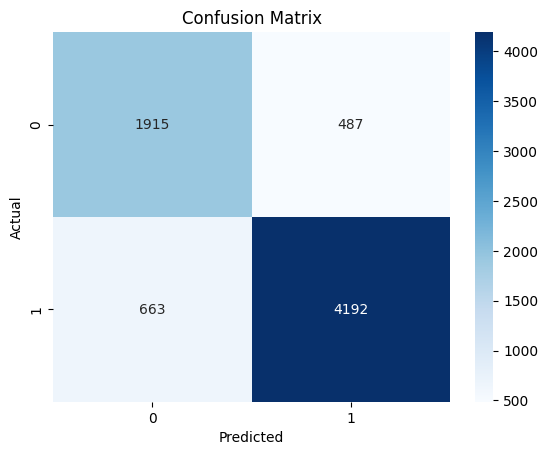

In [65]:
nn_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(nn_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Compare Models Recall on Canceled Class

In [66]:
dt_recall = round(dt_cm[0][0]/(dt_cm[0][0] + dt_cm[0][1]), 2)
rf_recall = round(rf_cm[0][0]/(rf_cm[0][0] + rf_cm[0][1]), 2)
nn_recall = round(nn_cm[0][0]/(nn_cm[0][0] + nn_cm[0][1]), 2)
recalls = [dt_recall, rf_recall, nn_recall]
model_names = ['Decision Tree', 'Random Forest', 'Neural Network']
recalls

[0.76, 0.82, 0.8]

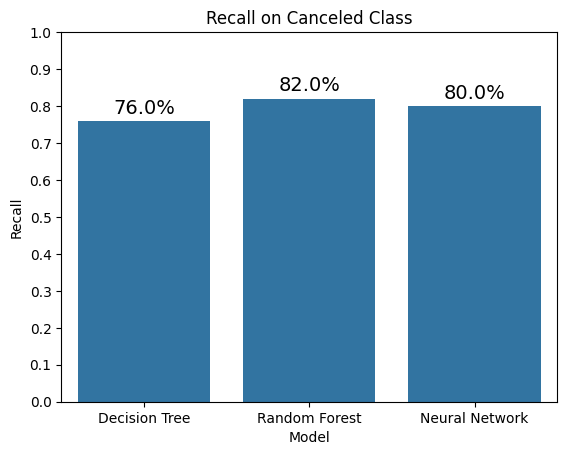

In [67]:
sns.barplot(x=model_names, y=recalls)
# Add labels for each bar
for i, recall in enumerate(recalls):
    plt.text(i, recall + 0.02, f'{recall * 100:.1f}%', ha='center', fontsize=14)
plt.title('Recall on Canceled Class')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

#### Selected Model for Deployment is Random Forest

## Step 9: Train The Selected Model for Deployment On All Data

In [69]:
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)
y.value_counts()

,count
booking status,
1,24396
0,24396


In [70]:
RF_model = Pipeline([
    ('Full Data Pipeline', full_pipline),
    ('Model', RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_leaf=2, min_samples_split=2)),
])
RF_model

Pipeline(steps=[('Full Data Pipeline',
                 ColumnTransformer(transformers=[('Numerical Pipeline',
                                                  Pipeline(steps=[('Features '
                                                                   'Engineering',
                                                                   FunctionTransformer(func=<function feature_engineering at 0x7f2a8e3617e0>)),
                                                                  ('Outlier '
                                                                   'Treatment',
                                                                   FunctionTransformer(func=<function outlier_treatment at 0x7f2a87fc1b40>,
                                                                                       kw_args={'features_name': ['lead '
                                                                                                                  'time',
                                                                                                                  'special '
                                                                                                                  'request...
                                                   'lead time',
                                                   'average price ',
                                                   'car parking space',
                                                   'repeated', 'P-C', 'P-not-C',
                                                   'special requests']),
                                                 ('Categorical Pipeline',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['room type', 'type of meal',
                                                   'market segment type'])])),
                ('Model',
                 RandomForestClassifier(min_samples_leaf=2, n_estimators=200))])

In [71]:
RF_model.fit(X, y)

Pipeline(steps=[('Full Data Pipeline',
                 ColumnTransformer(transformers=[('Numerical Pipeline',
                                                  Pipeline(steps=[('Features '
                                                                   'Engineering',
                                                                   FunctionTransformer(func=<function feature_engineering at 0x7f2a8e3617e0>)),
                                                                  ('Outlier '
                                                                   'Treatment',
                                                                   FunctionTransformer(func=<function outlier_treatment at 0x7f2a87fc1b40>,
                                                                                       kw_args={'features_name': ['lead '
                                                                                                                  'time',
                                                                                                                  'special '
                                                                                                                  'request...
                                                   'lead time',
                                                   'average price ',
                                                   'car parking space',
                                                   'repeated', 'P-C', 'P-not-C',
                                                   'special requests']),
                                                 ('Categorical Pipeline',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['room type', 'type of meal',
                                                   'market segment type'])])),
                ('Model',
                 RandomForestClassifier(min_samples_leaf=2, n_estimators=200))])

### Save The Model on Drive

In [72]:
model_path = '/content/drive/MyDrive/models'
os.makedirs(model_path, exist_ok=True)
joblib.dump(RF_model, os.path.join(model_path, 'RF_model.pkl'))

['/content/drive/MyDrive/models/RF_model.pkl']